## Analysis of quadrupolar NMR spectra

This notebook implements a spectral analysis of nuclear magnetic resonance (NMR) and nuclear quadrupole resonance (NQR) spectra for a crystal structure with arbitrary spin number. Here a single spin sensor (i.e. an individual nitrogen-vacancy (NV) center in diamond) is used to probe nuclear spins within the crystal. 

The analysis below follows the procedure developed in "Nanoscale Magnetic Resonance Spectroscopy of an Atomically Thin Material Using a Single Spin Qubit" by Lovchinsky et. al., 2016.
<hr>

Application of a dynamical decoupling pulse sequence with $k$ pulses and a free evolution interval $\tau$ leads to a population signal of the form $S(\tau) = \frac{1}{2}\big(1- \cos \phi\big)$, where $\phi$ is the total accumulated phase at the end of the pulse sequence. Averaging over many realizations and assuming that the accumulated phase is Gaussian-distributed with zero mean, the signal becomes 

\begin{align}
S(\tau) = \frac{1}{2}\Big(1- e^{- \left\langle \phi^2 \right\rangle /2}\Big)
\end{align} 

Here the phase variance $\left\langle \phi^2 \right\rangle$ is given by

\begin{align}
\left\langle \phi^2 \right\rangle = \frac{\gamma_{e}^2}{2\pi} \int_{-\infty}^{\infty} d\omega S_{B}(\omega) |g(\omega \tau)|^2,
\end{align}

where $\gamma_{e}$ is the electron gyromagnetic ratio, $S_{B}(\omega)$ is the double-sided magnetic spectral density and $|g(\omega)|^2$ is the detector filter function. For an XY8-$k$ dynamical decoupling pulse sequence, the filter function is given by

\begin{align}
|g(\omega \tau)|^2 = 2 \sin^2 \Bigg(\frac{(k+1)\omega\tau}{2} \Bigg) \tan^2 \Big(\frac{\omega\tau}{2} \Big),
\end{align}

where we have neglected evolution during the spin rotations. The spectral density for a uniform spin distribution of thickness $h$ is given by the expression

\begin{align}
S_{B}(\omega) = 9 \rho \Big( \frac{\mu_0 \hbar \gamma_{n}}{4\pi} \Big)^2 \Big(\tilde{\Gamma}_x f^{x,x}(\omega) + \tilde{\Gamma}_y f^{y,y}(\omega) \Big),
\end{align}

where $\rho$ is the spin density, $\mu_0$ is the vacuum permeability, $\hbar$ is the reduced Planck's constant and $\gamma_n$ is the gyromagnetic ratio of the target nuclear spin species. The geometrical factors $ \tilde{\Gamma}_x$ and $ \tilde{\Gamma}_y$ depend on the NV depth $d$ and the angle $\alpha$ of the NV symmetry axis relative to the surface normal and are given by the expressions

\begin{align}
 \tilde{\Gamma}_x(\alpha) = -\frac{\pi}{3} \Bigg(\frac{3 \cos(4 \alpha) - 35}{768}\Bigg) \Bigg[\frac{1}{d^3} - \frac{1}{(d+h)^3} \Bigg] \\
 \tilde{\Gamma}_y(\alpha)  = \frac{\pi}{3} \Bigg(\frac{3 \cos(2\alpha) + 5}{192} \Bigg) \Bigg[\frac{1}{d^3} - \frac{1}{(d+h)^3} \Bigg].
\end{align}

For the special case of a [100]-oriented diamond, where the NV symmetry axis makes a $\sim$54.7$^{\circ}$ angle relative to the surface normal, these expressions reduce to

\begin{align}
 \tilde{\Gamma}_x = \frac{7 \pi}{432} \Bigg[\frac{1}{d^3} - \frac{1}{(d+h)^3} \Bigg] \\
 \tilde{\Gamma}_y = \frac{\pi}{144} \Bigg[\frac{1}{d^3} - \frac{1}{(d+h)^3} \Bigg].
\end{align}

The transverse correlation functions $f^{x,x}$ and $f^{y,y}$ are given by

\begin{align}
f^{x,x}(\omega) = \frac{2}{Tr(\textbf{1})} \sum_{n,m} \Big| \left\langle n \right| I_x \left| m \right\rangle \Big|^2 \delta \big( \Delta \omega_{n,m} - \omega \big) \\
f^{y,y}(\omega) = \frac{2}{Tr(\textbf{1})} \sum_{n,m} \Big| \left\langle n \right| I_y \left| m \right\rangle \Big|^2 \delta \big( \Delta \omega_{n,m} - \omega \big),
\end{align}

where $Tr(\textbf{1})$ denotes the trace of the identity operator for the target nuclear spin, $\textbf{I}$ = $\{I_x,I_y,I_z\}$ are the generalized spin matrices, and the indices $n$ and $m$ correspond to the complete set of spin eigenstates of the nuclear spin where the energy difference of the states is given by $\omega_{n,m}$. Note that each pair of eigenstates corresponds to two spectral lines, one at a positive and one at a negative frequency. Diagonalization of the nuclear Hamiltonian 

\begin{align}
H_Q = \frac{\overline{Q}}{4I(2I-1)} \Big[ 3 I_z^2 - I^2 + \eta (I_x^2 - I_y^2) \Big]  + \hbar \gamma_n \textbf{I} \cdot \textbf{B},
\end{align}

where $\textbf{B}$ is the external applied magnetic field, yields a set of energy eigenvalues and eigenstates which can be used to evaluate the correlation functions above. The parameter $\overline{Q}$ is the quadrupole coupling contstant, proportional to the local electric field gradient and the quantity $\eta$ is known as the asymmetry parameter and is related to the degree of deviation from axial symmetry in a material. In the absence of an applied magnetic field the eigenstates of $H_Q$ define a principal axis coordinate system. In axially symmetric materials, this coordinate system is parametrized by a single axis.

In the preceding analysis, we have implicitly assumed that the nuclear spins are non-interacting. In order to (approximately) capture the effects of interactions we replace the delta-function resonances in the magnetic spectral density with Lorentzian functions of width $\gamma$:

The following code implements this model.
<hr>

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from sklearn import linear_model
import numpy.matlib as npm
import warnings
warnings.filterwarnings('ignore')

The following block of functions load the spectrum data, parameters and fundamental constants.

In [2]:
def initializeParameters(filename):
    """
    This function reads in text file containing spectrum parameters and creates dictionary 
    containing variable names and values.
    
    Args: 
        filename (str): Filename of parameter file.
        
    Returns:
        Python dictionary containing key/value pairs corresponding to parameter names and 
        value.
        
    """

    # open text file containing parameter values
    F = open(filename, 'r')
    parameter_text = F.readlines()
    F.close() 

    # populate dictionary
    pardict = {}
    for item in parameter_text:
        parrow = item.split()
        pardict[parrow[0]] = float(parrow[1])
    return pardict

def initializeConstants(filename):
    """
    This function reads in text file containing fundamental constants and creates dictionary 
    containing constant names and values.
    
    Args: 
        filename (str): Filename of constants file.
        
    Returns:
        Python dictionary containing key/value pairs corresponding to constant names and value.
        
    """

    # open text file containing parameter values
    F = open(filename, 'r')
    constant_text = F.readlines()
    F.close()

    # populate dictionary
    constdict = {}
    for item in constant_text:
        constrow = item.split()
        constdict[constrow[0]] = float(constrow[1])
    
    return constdict

def loadData(filename):
    """
    This function reads in a spectrum file.
    
    Args: 
        filename (str): Filename of spectrum file.
        
    Returns:
        Free precession interval array, spectrum and error.
        
    """

    # open file and parse data
    data = np.loadtxt(filename)

    taus = data[:,0]
    sig = data[:,1]
    sigerr = abs(data[:,2])
    
    return taus, sig, sigerr

The following block of functions create generalized Pauli spin operators for an arbitrary spin.

In [3]:
def createSpinOperators(spin):
    """
    This function creates a set of generalized Pauli spin operators for spin of arbitrary 
    size. 
    
    Args: 
        spin (float): Spin quantum number [ex. 1.5].
        
    Returns:
        List of generalized spin matrices consisting of sigma-x, sigma-y, sigma-z and the 
        identity.
        
    """
    
    num_states = int(2*spin+1) # dimension of Hilbert space
    
    # initialize Sigma matrices
    Sigma_X = npm.zeros((num_states,num_states), dtype = np.complex)
    Sigma_Y = npm.zeros((num_states,num_states), dtype = np.complex)
    Sigma_Z = npm.zeros((num_states,num_states), dtype = np.complex)

    # Populate diagonal elements of Sigma_Z
    for i in range(num_states):
        Sigma_Z[i,i] = spin - i


    # Calculate off-diagonal elements for Sigma_X and Sigma_Y
    off_diag_entries = []
    for i in range(num_states-1):
        if i:
            next_entry = abs(2*(spin - i) + off_diag_entries[i-1]**2)
            off_diag_entries.append(np.sqrt(next_entry))
        else:
            next_entry = abs(2*(spin - i))
            off_diag_entries.append(np.sqrt(next_entry))
    
    # Populate off-diagonal elements of Sigma_X and Sigma_Y
    cnt = 0
    for entry in off_diag_entries:
        Sigma_X[cnt,cnt+1] = entry/2
        Sigma_X[cnt+1,cnt] = entry/2
        Sigma_Y[cnt,cnt+1] = -1j*entry/2
        Sigma_Y[cnt+1,cnt] = 1j*entry/2
        cnt += 1
        
    # Create Identity
    Sigma_0 = npm.identity(int(2*spin+1), dtype = int) 
        
    return [Sigma_X, Sigma_Y, Sigma_Z, Sigma_0]

def rotateMatrix(ang):
    """
    This function creates a composite rotation matrix for a list of angles about X,Y and 
    Z axes, respectively.
    
    Args: 
        ang : List of angles (in radians) for rotations about x, y and z axes, respectively.
        
    Returns:
        NumPy matrix (of size 3x3) for composite rotation.
        
    """

    # Define 3D rotation matrices for angle vector ang
    Rotx_3D = np.mat([[1,0,0],[0,np.cos(ang[0]),-np.sin(ang[0])], \
                      [0,np.sin(ang[0]),np.cos(ang[0])]])
    Roty_3D = np.mat([[np.cos(ang[1]),0,np.sin(ang[1])],[0,1,0], \
                      [-np.sin(ang[1]),0,np.cos(ang[1])]])
    Rotz_3D = np.mat([[np.cos(ang[2]),-np.sin(ang[2]),0], \
                      [np.sin(ang[2]),np.cos(ang[2]),0],[0,0,1]])
    
    return Rotx_3D*Roty_3D*Rotz_3D

The following class defines a Hamiltonian, corresponding to the nuclear spin species.

In [4]:
class Hamiltonian:
    """
    This is a Hamiltonian operator class that allows us to construct a matrix representation 
    for a quadrupolar spin (of arbitrary size) Hamiltonian. The interactions that can be 
    included are the Zeeman interaction and the Quadrupolar interaction (including the 
    quadrupole coupling constant and a non-zero asymmetry parameter).        
        
    """
    
    def __init__(self,spin,gyro):
        """
        The __init__ method creates a Hamiltonian object. The 'spin' and 'gyro' 
        fields are initialized. The set containing term labels is initialized to the empty 
        set and the matrix representation is initialized to the zero matrix. The method 
        calls function 'createSpinOperators' to construct the generalized Pauli spin vector 
        operators for the nuclear spin. 
        
        Args: 
            spin: Spin quantum number of nuclear spin.
            gyro: Nuclear spin gyromagnetic ratio.
            
        """
        
        self.spin = spin
        
        self.gyro = gyro
        
        # create spin operators
        self.SpinOperators = createSpinOperators(spin)
        
        # initialize matrix representation
        HilbSpace_size = int(2*spin+1) # dimension of Hilbert space
        self.H_MatrixRep = npm.zeros((HilbSpace_size,HilbSpace_size), dtype = np.complex)
        self.terms = set()
    
    def __str__(self):
        """
        This method prints a string containing the current terms in the Hamiltonian
        
        Args: 
            None
            
        """
        
        outstring = 'Current Hamiltonian terms: '
        for item in self.terms:
            outstring += item + ', '
        outstring = outstring[0:-2]
        return outstring
        
    def add_Zeeman(self,fieldMag,fieldAng):
        """
        This method creates a Zeeman term in the Hamiltonian. The Zeeman term is added to 
        the Hamiltonian matrix representation and a separate matrix is created. 
        
        Args: 
            fieldMag: Magnitude of applied magnetic field [G].
            fieldAng: Angle of applied magnetic field [rad]. 
            
        """
        
        if 'Zeeman' not in self.terms:
            angDep = [0, np.sin(fieldAng), np.cos(fieldAng)]
            self.Zeeman_MatrixRep = npm.zeros(self.H_MatrixRep.shape, dtype = np.complex)
            for i in range(1,3):
                self.Zeeman_MatrixRep += C['hbar']*2*np.pi*fieldMag*angDep[i]* \
                    (self.gyro*self.SpinOperators[i])

            # add to total Hamiltonian matrix representation
            self.H_MatrixRep += self.Zeeman_MatrixRep
            self.terms.add('Zeeman') # add label to terms list
        else: 
            print('Hamiltonian already contains Zeeman term.')
            
    def add_nuclearQuadrupolar(self,Q,eta,NVang):
        """
        This method creates a nuclear Quadrupolar term in the Hamiltonian. The 
        quadrupolar term is added to the Hamiltonian matrix representation and a separate 
        matrix is created. 
        
        Args: 
            Q: Quadrupole coupling constant [Hz].
            eta: Asymmetry parameter.
            NVang: Symmetry axis orientation (in radians) for sensor spin.
            
        """
        
        if 'Nuclear Quadrupolar' not in self.terms:
            # create rotation matrix for transformation into NV coordinate system
            RotMatrix = rotateMatrix([NVang,0,0])

            # Initialize Quadrupolar Matrix
            Cmat = C['hbar']*2*np.pi*Q/(4*self.spin*(2*self.spin-1))* \
                np.array([[eta,0,0],[0,-eta,0],[0,0,3]])
            Cmat = np.linalg.inv(RotMatrix)*Cmat*RotMatrix # transform to NV coordinates

            # populate Quadrupolar terms
            self.nuclearQuadrupolar_MatrixRep = npm.zeros(self.H_MatrixRep.shape, \
                dtype = np.complex)
            for i in range(3):
                for j in range(3):
                    self.nuclearQuadrupolar_MatrixRep += Cmat[i,j]* \
                        self.SpinOperators[i]*self.SpinOperators[j]

            # add to total Hamiltonian matrix representation
            self.H_MatrixRep += self.nuclearQuadrupolar_MatrixRep
            self.terms.add('Nuclear Quadrupolar') # add label to terms list
        else: 
            print('Hamiltonian already contains nuclear quadrupolar term.')

            
    def remove_Zeeman(self):
        """
        This method removes the Zeeman term from the Hamiltonian and the terms list set.
        
        Args: 
            None 
            
        """
        
        if 'Zeeman' in self.terms:
            self.H_MatrixRep -= self.Zeeman_MatrixRep # remove from Hamiltonian
            self.Zeeman_MatrixRep = None
            self.terms.remove('Zeeman') # remove label from terms list set
        else:
            print('Hamiltonian has no Zeeman term.')
            
    def remove_nuclearQuadrupolar(self):
        """
        This method removes the nuclear quadrupolar term from the Hamiltonian and the terms 
        list set.
        
        Args: 
            None 
            
        """
        
        if 'Nuclear Quadrupolar' in self.terms:
            self.H_MatrixRep -= self.nuclearQuadrupolar_MatrixRep # remove from Hamiltonian
            self.nuclearQuadrupolar_MatrixRep = None
            self.terms.remove('Nuclear Quadrupolar') # remove label from terms list set
        else:
            print('Hamiltonian has no nuclear quadrupolar term.')

The following functions perform the spectral fit and display the resulting parameters.

In [5]:
def modelSpectrum(tau,depth,fieldMag,fieldAng,gamma,quadrupoleConst):
    """
    This function performs the spectral fit using a non-linear least squares algorithm.
    
    Args: 
        tau : List of free precession intervals [ns].
        depth: Depth of sensor [nm].
        fieldMag: Magnitude of external magnetic field [G].
        fieldAng: Angle of external magnetic field [rad].
        gamma: Decoherence rate of nuclear spins [Hz].
        quadrupoleConst: Quadrupole Coupling Constant [Hz].
        
    Returns:
        Model of NMR spectrum.
        
    """
    
    # create Hamiltonian object
    H = Hamiltonian(P['spin'],P['Ngyro'])
    H.add_Zeeman(fieldMag,fieldAng) # add Zeeman interactions
    H.add_nuclearQuadrupolar(quadrupoleConst,0,P['NVang']) # add Quadrupolar interaction
    
    # create Pauli spin operators
    I = createSpinOperators(P['spin'])
    
    # calculate eigenvectors and eigenvalues of model Hamiltonian
    eigVal,eigVec = np.linalg.eig(H.H_MatrixRep)
    
    # define spectral range in frequency space
    tau = tau*10**-9 # convert to [s]
    depth = depth*10**-9 # convert to [m]
    omega = 0.5*np.linspace(2*np.pi/tau[-1]-20*gamma,2*np.pi/tau[0]+20*gamma,1000)

    # calculate correlation functions
    f_xx = np.zeros(len(omega))
    f_yy = np.zeros(len(omega))
    
    for i in range(len(eigVal)):
        for j in range(len(eigVal)):
            # transition frequency of states i and j
            omega_nm = np.real(eigVal[i] - eigVal[j])/C['hbar']
            
            # matrix element for states i and j
            elem_x = np.real(np.transpose(eigVec[:,i])*I[0]*eigVec[:,j]* \
                np.conj(np.transpose(eigVec[:,i])*I[0]*eigVec[:,j]))
            elem_y = np.real(np.transpose(eigVec[:,i])*I[1]*eigVec[:,j]* \
                np.conj(np.transpose(eigVec[:,i])*I[1]*eigVec[:,j]))

            f_xx += 2/np.trace(I[3])*np.float(elem_x)*gamma/ \
                (gamma**2 + (omega-omega_nm)**2)/np.pi
            f_yy += 2/np.trace(I[3])*np.float(elem_y)*gamma/ \
                (gamma**2 + (omega-omega_nm)**2)/np.pi
    
    # geometrical factors
    Gamma_x = 7*np.pi/432/depth**3
    Gamma_y = np.pi/144/depth**3
    
    spinDensity = P['density']*10**27 # convert spin density to [m^-3]
    S_B = 9*spinDensity*(C['u_0']*C['hbar']*P['Ngyro']/ \
        (4*np.pi))**2*(f_xx*Gamma_x + f_yy*Gamma_y)
    
    # calculate signal variance for all tau
    phi = np.zeros(len(tau))
    for i in range(len(tau)):
        filterFunction = 2*np.sin((P['Npi']+1)*omega*tau[i]/2)**2*np.tan(omega*tau[i]/2)**2
        integrand = np.trapz(filterFunction*S_B,omega)
        phi[i] = 2*C['Egyro']**2/(np.pi)*integrand
    
    # calculate population signal
    popSignal = 0.5*(1-np.exp(-(2*np.pi)**4*phi))
    
    return popSignal

def displayFitResults(paramName,bestFitParameters,cov):
    """
    This function displays results of the spectral fit.
    
    Args: 
        paramName : List of labels for free parameters.
        bestFitParameters: List of best-fit parameters.
        cov: Covariance matrix.
        
    Returns:
        None
        
    """
    # create tuples of parameter name,value
    paramPairs = list(zip(paramName,bestFitParameters))
    
    # estimate 1-sigma error
    perrs = np.sqrt(np.diag(cov))
    
    # print results
    print("Extracted Parameters using Non-Linear Least Squares Analysis")
    print("==============================================================")
    for i in range(len(paramName)):
        print(paramPairs[i][0], ': ', '%.3g' % paramPairs[i][1], \
              '+/-', '%.3g' % perrs[i])

<hr>
# Non-linear least squares analysis

As an example, let's consider the $^{11}$B NQR spectrum of hexagonal boron nitride (h-BN). Hexagonal boron nitride is an insulating material consisting of equal concentrations of boron (80$\%$ $^{11}$B, 20$\%$ $^{10}$B) and nitrogen (close to 100$\%$ $^{14}$N) in a honeycomb layered structure. The individual atomic layers of h-BN are held together by weak van der Waals interactions, allowing the preparation of samples with varying numbers of layers via mechanical exfoliation. Nanometer-thick h-BN flakes have been extensively used as dieletric spacers and passivation layers for graphene and transition metal dichalcognides. Recent studies have shown that atomically thin h-BN can be the host for interesting quantum defects. Here we load the data and use our model function to perform a non-linear least squares fit on the data.

In [10]:
# load data
tau, sig, sigerr = loadData('hBNdata.txt')

# initialize parameters
P = initializeParameters('parameters_hBN.txt')

# initialize constants
C = initializeConstants('constants_hBN.txt')

# define free parameters and starting values
Params = ['NV Depth [nm]', 'B-field Magnitude [G]', 'B-field Angle [rad]', \
        'Decoherence Rate [Hz]', 'Quadrupole Coupling Constant [Hz]']
initialParam = [4,30,0,20000,2.924e6]

# perform spectral fit
modelSig, cov = curve_fit(modelSpectrum, tau, sig, p0 = initialParam, sigma = sigerr)
bestFit = modelSpectrum(tau, modelSig[0], modelSig[1], modelSig[2], modelSig[3], modelSig[4])

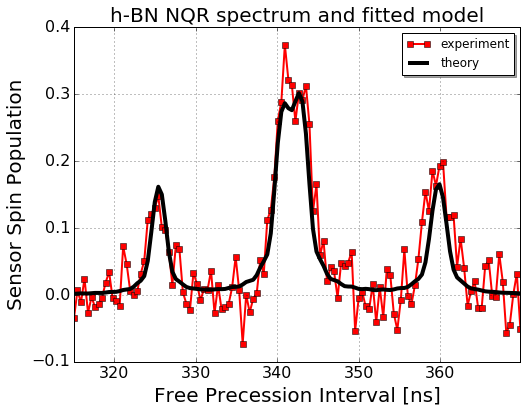

Extracted Parameters using Non-Linear Least Squares Analysis
NV Depth [nm] :  5.13 +/- 0.0405
B-field Magnitude [G] :  30.1 +/- 0.0973
B-field Angle [rad] :  0.0649 +/- 0.00344
Decoherence Rate [Hz] :  1.13e+04 +/- 895
Quadrupole Coupling Constant [Hz] :  2.92e+06 +/- 360


In [12]:
# plot results
fig = plt.figure(figsize=[8,6])
plt.plot(tau,sig,'rs-', linewidth = 2, label = 'experiment')
plt.plot(tau,bestFit,'k', linewidth = 4, label = 'theory')

axes = fig.add_subplot(111)
axes.set_title('h-BN NQR spectrum and fitted model', fontsize = 20)
axes.set_xlabel('Free Precession Interval [ns]', fontsize = 20)
axes.set_ylabel('Sensor Spin Population', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=16)
legend = axes.legend(loc='upper right', shadow=True)
plt.xlim(tau[0],tau[-1])
plt.grid(True)
plt.show()

# desplay the resulting parameters, with estimates of 1-sigma errors
displayFitResults(Params, modelSig, cov)

# Bayesian approach (using Metropolis-Hastings sampling)
Some of the parameters used in the model are known (or approximated) from other, independent measurements. In order to incorporate these priors, we can use a Bayesian approach. Since the normalization constant in Bayes' rule is not <i>a priori</i> known, the posterior cannot be evaluated. Moreover, the posterior is high-dimensional and sampling the entire space is not feasible. However, we can use a Markov chain Monte Carlo (MCMC) approach to draw samples from the posterior. In particular, here we use the Metropolis Hastings algorithm.  

In [13]:
def initializePriors(filename):
    """
    This function reads in text file containing prior parameters and creates dictionary 
    containing variable names and values.
    
    Args: 
        filename (str): Filename of prior file.
        
    Returns:
        Python dictionary containing key/value pairs corresponding to prior names and 
        values.
        
    """

    # open text file containing prior values
    F = open(filename, 'r')
    parameter_text = F.readlines()
    F.close() 

    # populate dictionary
    priordict = {}
    for item in parameter_text:
        priorrow = item.split()
        priordict[priorrow[0]] = float(priorrow[1])
    return priordict

def logPrior(depth,fieldMag,fieldAng,gamma,quadrupoleConst,priordict):
    """
    This function calculates a quantity that is proportional to the prior on the 
    fit parameters. The field angle and decoherence rate do not have priors and 
    are assumed to be uniform.
    
    Args: 
        depth: Depth of sensor [nm].
        fieldMag: Magnitude of external magnetic field [G].
        fieldAng: Angle of external magnetic field [rad].
        gamma: Decoherence rate of nuclear spins [Hz].
        quadrupoleConst: Quadrupole Coupling Constant [Hz].
        priordict: Dictionary containing prior values.
        
    Returns:
        Quantity that is proportional to prior probability.
        
    """
    
    # calculate priors for depth, field magnitude and quadrupole coupling constant
    # the other two parameters have uniform priors and do not have to be included
    depth_p = -(depth-priordict['Depth'])**2/(2*priordict['Depth_std']**2)
    fieldMag_p = -(fieldMag-priordict['Bmag'])**2/(2*priordict['Bmag_std']**2)
    quadrupoleConst_p = -(quadrupoleConst-priordict['Q'])**2/(2*priordict['Q_std']**2)

    return depth_p + fieldMag_p + quadrupoleConst_p

def logLikelihood(tau,sig,sigerr,depth,fieldMag,fieldAng,gamma,quadrupoleConst):
    """
    This function calculates the probablity that the data originated from an underlying 
    model (as calculated by 'modelSpectrum') assuming that the errors are Gaussian 
    distributed with standard deviation given by the error in the measurement.
    
    Args: 
        tau: Free precession interval [ns].
        sig: Experimental NMR spectrum
        sigerr: Error on experimental NMR spectrum
        depth: Depth of sensor [nm].
        fieldMag: Magnitude of external magnetic field [G].
        fieldAng: Angle of external magnetic field [rad].
        gamma: Decoherence rate of nuclear spins [Hz].
        quadrupoleConst: Quadrupole Coupling Constant [Hz].
        
    Returns:
        Probability of getting data from underlying model assuming errors are Gaussian 
        distributed.
        
    """
    
    # calculate model spectrum
    model = modelSpectrum(tau,depth,fieldMag,fieldAng,gamma,quadrupoleConst)
    
    # calculate likelihood probability
    pLogLikelihood = 0
    for i in range(len(tau)):
        pLogLikelihood += -(sig[i]-model[i])**2/(2*sigerr[i]**2) - \
            np.log(np.sqrt(2*sigerr[i]**2*np.pi))
    return pLogLikelihood

def logPosterior(x):
    """
    This function calculates a quantity proportional to the log posterior.
    
    Args: 
        x: List of values corresponding to the point in sample space.
        
    Returns:
        Sum of log likelihood and log prior.
        
    """
    posterior = logLikelihood(tau,sig,sigerr,x[0],x[1],x[2],x[3],x[4])+ \
        logPrior(x[0],x[1],x[2],x[3],x[4],priordict)
    return posterior

Now we write a Metropolis-Hastings sampling algorithm. Here we use the standard trick of sampling the log-posterior, in order to deal with small numbers.

In [14]:
def MetropolisHastings(sample,N_mc):
    """
    This function generates samples from the posterior.
    
    Args: 
        sample: List of values corresponding to starting point in sample space.
        N_mc: Number of Monte Carlo iterations.
        
    Returns:
        Array of samples from posterior.
        
    """
    u = np.random.random(N_mc) # choose N_mc random numbers
    
    x_star = np.zeros(len(sample))
    x_prev = sample
    
    # proposal distribution, standard deviations
    proposal = [0.003,0.01,0.005,300,10]

    # initialize sample array
    samp = np.zeros((N_mc,len(x_prev)))
    
    # perform MH sampling
    for i in range(N_mc):
        for j in range(len(x_prev)):
            x_star[j] = np.random.normal(x_prev[j],proposal[j])

        # calculate posterior ratio
        A = logPosterior(x_star) - logPosterior(x_prev)
        if np.log(u[i]) < A:
            for j in range(len(x_prev)):
                x_prev[j] = x_star[j]
            
        samp[i,:] = x_prev
        
    return samp

In [15]:
# initialize priors
priordict = initializePriors('priors_hBN.txt')

# initialize MCMC parameters
N_mc = 100000 # number of MC iterations
x0 = modelSig # use results of previous fit as starting parameters

# generate samples from posterior
samp = MetropolisHastings(x0,N_mc)

Before we can analyze the results, we have to consider the issue of a burn-in time. Specifically, since the sampler is initialized at a point which may not be the maximum value of the posterior, it is customary to remove points until the sampler looks converged. Below we plot the individual sample trajectories to determine the burn-in time. Here the start point was modified until the sampler begins in equilibrium.

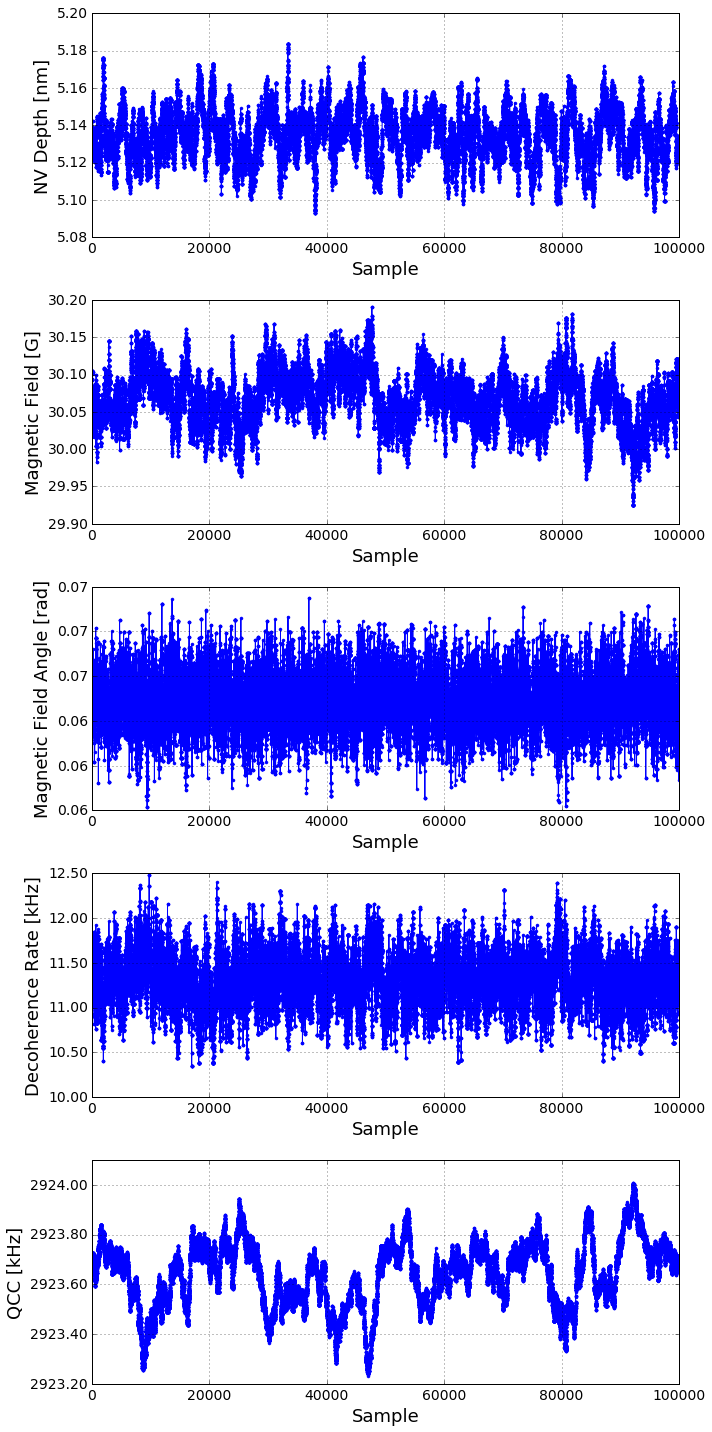

In [44]:
cnt = 0

# label variables
variable = ['NV Depth [nm]','Magnetic Field [G]','Magnetic Field Angle [rad]', \
            'Decoherence Rate [kHz]', 'QCC [kHz]'] 

# make 1x5 grid
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20), tight_layout = True) 
for ax in axes.ravel():
    if cnt > 2:
        ax.plot(samp[:,cnt]/1000,'b.-') # convert to kHz
    else:
        ax.plot(samp[:,cnt],'b.-')
    ax.set_xlabel('Sample', fontsize=18)
    ax.set_ylabel(variable[cnt], fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(True)
    cnt += 1

<hr>
Since the external magnetic field magnitude and angle are parameters that we control, let's put those variables aside and consider the more meaningful variables, namely depth, decoherence rate and quadrupole coupling constant. We can visualize the 3D projection of the full posterior by using a scatter plot. Here the shift in the quadrupole coupling constant (QCC) is relative to the mean value.

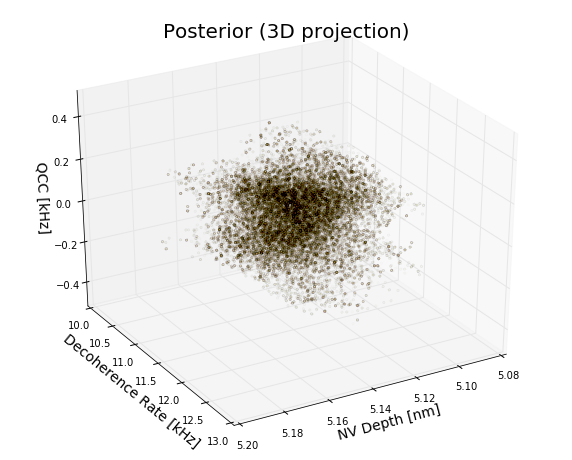

In [34]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(samp[:,0], samp[:,3]/1000, (samp[:,4]-np.mean(samp[:,4]))/1000, \
    c = "goldenrod", marker='.', alpha = 0.01)

ax.set_title('Posterior (3D projection)', fontsize = 20)
ax.set_xlabel('NV Depth [nm]', fontsize=14)
ax.set_ylabel('Decoherence Rate [kHz]', fontsize=14)
ax.set_zlabel('QCC [kHz]', fontsize=14)
ax.view_init(azim=60)

plt.show()

We can also visualize the posterior in 2D projections. In this case it is a bit easier to interpret. As an example, two projections of the posterior are plotted below. 

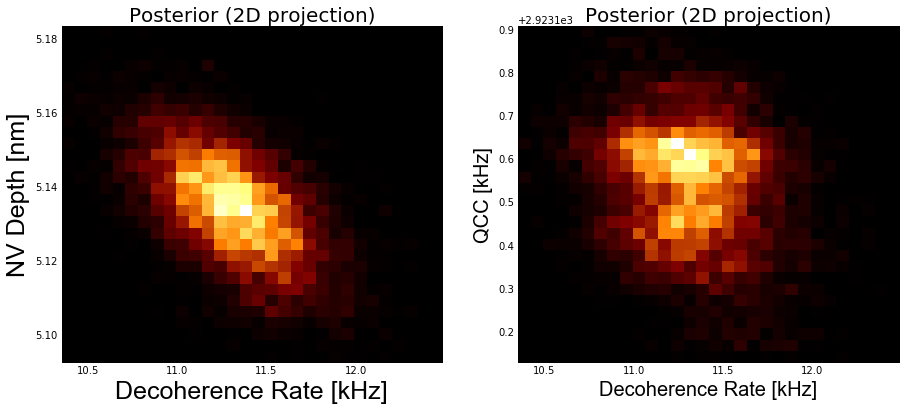

In [33]:
fig = plt.figure(figsize=[15,6])
axes = fig.add_subplot(121)
axis_font = {'fontname':'Arial', 'size':'25'}
plt.hist2d(samp[:,3]/1000, samp[:,0],30, cmap = 'afmhot')
axes.set_title('Posterior (2D projection)', fontsize = 20)
plt.xlabel("Decoherence Rate [kHz]", **axis_font)
plt.ylabel("NV Depth [nm]", **axis_font)

axes = fig.add_subplot(122)
axis_font = {'fontname':'Arial', 'size':'20'}
plt.hist2d(samp[:,3]/1000, samp[:,4]/1000,30, cmap = 'afmhot')
axes.set_title('Posterior (2D projection)', fontsize = 20)
plt.xlabel("Decoherence Rate [kHz]", **axis_font)
plt.ylabel("QCC [kHz]", **axis_font)

Now we can print out the extracted parameters. As we can see, the Bayesian analysis gives tigher confidence intervals due to the presense of the priors.

In [35]:
# print results
print("Extracted Parameters using Bayesian Approach")
print("============================================")
for i in range(len(Params)):
    print(Params[i], ': ', '%.3g' % np.mean(samp[:,i]), '+/-', '%.3g' % np.std(samp[:,i]))

Extracted Parameters using Bayesian Approach
NV Depth [nm] :  5.13 +/- 0.0131
B-field Magnitude [G] :  30.1 +/- 0.035
B-field Angle [rad] :  0.0649 +/- 0.00115
Decoherence Rate [Hz] :  1.13e+04 +/- 288
Quadrupole Coupling Constant [Hz] :  2.92e+06 +/- 128


<hr>
# Custering and classification of NMR spectra into bulk, bilayer and monolayer configurations

Using a model of this form, we can extract the quadrupole coupling constants and decoherence rates (linewidths) for a number of measurements. We did this for several bulk h-BN measurements, bilayer measurements and monolayer measurements. Now we would like to see if we can predict the configuration (bulk, bilayer or monolayer) based on the extracted parameters. For this purpose, we first use K-means clustering.

In [36]:
def loadMultiData(filename):
    """
    This function reads in a spectrum file.
    
    Args: 
        filename (str): Filename of spectrum file.
        
    Returns:
        Free precession interval array, spectrum and error.
        
    """

    # open file and parse data
    data = np.loadtxt(filename)

    Q = data[:,0]
    Q_err = data[:,1]
    gamma = data[:,2]
    gamma_err = data[:,3]
    depth = data[:,4]
    depth_err = data[:,5]
    classify = data[:,6]
    
    return [Q,Q_err,gamma,gamma_err,depth,depth_err,classify]

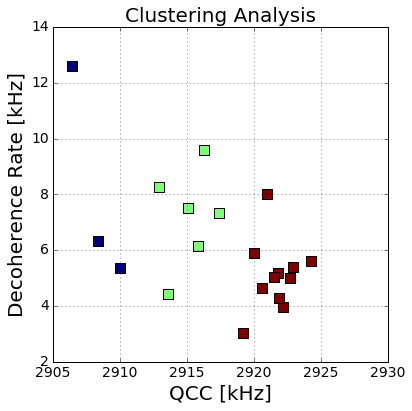

In [37]:
# load data
multiData = loadMultiData('hBN_multispectra.txt')

# zip data together for clustering
clusterData = zip(multiData[0],multiData[2])
clusterDataList = [list(x) for x in clusterData]

# perform K-means clustering
clusters = KMeans(n_clusters=3, random_state=0).fit(clusterDataList)

# plot results
fig = plt.figure(figsize=[6,6])
plt.scatter(multiData[0]/1000, multiData[2]/1000, c=clusters.labels_, marker = 's', s = 100) 

axes = fig.add_subplot(111)
axes.set_title('Clustering Analysis', fontsize = 20)
axes.set_xlabel('QCC [kHz]', fontsize = 20)
axes.set_ylabel('Decoherence Rate [kHz]', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.show()

Now we can calculate how well we did. For the dataset shown above, we have independent measurements of the configuration, so we can calculate the clustering success probability. 

In [38]:
print("Clustering Score: ", np.sum(clusters.labels_ == multiData[-1])/len(multiData[-1]))

Clustering Score:  1.0


We can see that the success probability is 100% for this data set. 

Another (perhaps better) approach is to use a clasifier (i.e. logistic regression) although it would be helpful to have more data for training and testing:

In [65]:
# load data
multiData = loadMultiData('hBN_multispectra.txt')

# zip data together for classification
clusterData = zip((multiData[0] - np.mean(multiData[0])), \
    (multiData[2] - np.mean(multiData[2])))
clusterDataList = [list(x) for x in clusterData]

# first define training set as complete dataset
x_train = clusterDataList
y_train = list(multiData[-1])

# first define test set as empty 
x_test = []
y_test = []

# now remove 3 random elements from training set and add to test set
for i in range(3):
    chooseElem = np.random.choice(len(x_train))
    x_test.append(x_train.pop(chooseElem))
    y_test.append(y_train.pop(chooseElem))

# convert to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

# perform logistic regression
logreg = linear_model.LogisticRegression(C = 1e5, max_iter = 1e5, warm_start = True)
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100000.0,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=True)

Now evaluate performance on test points

In [66]:
print("Test Set: ", list(map(int, y_test)))
print("Predictions: ", list(map(int, logreg.predict(x_test))))

Test Set:  [2, 2, 0]
Predictions:  [2, 2, 0]


Finally, we can visualize this classifier by plotting the boundaries on a scatter plot:

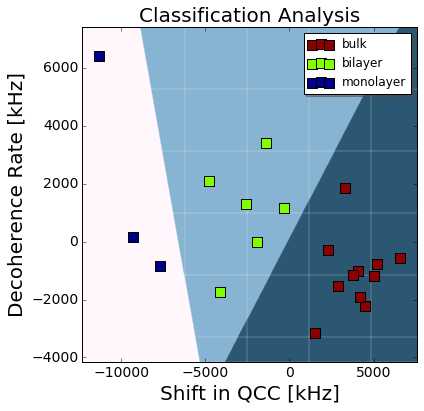

In [67]:
clusterData = zip(multiData[0] - np.mean(multiData[0]), \
    multiData[2] - np.mean(multiData[2]),multiData[-1])
clusterDataList = [list(x) for x in clusterData]

# split up data into categories
bulk = np.array([x for x in clusterDataList if x[2] == 2])
bilayer = np.array([x for x in clusterDataList if x[2] == 1])
monolayer = np.array([x for x in clusterDataList if x[2] == 0])

X = np.array(clusterDataList)    

# get boundaries
x_min = X[:, 0].min() - 1e3
x_max = X[:, 0].max() + 1e3
y_min = X[:, 1].min() - 1e3
y_max = X[:, 1].max() + 1e3

# make meshgrid of predictions
XX, YY = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
Z = logreg.predict(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

# plot the result
fig = plt.figure(figsize=(6, 6))
plt.pcolormesh(XX, YY, Z, cmap='PuBu', alpha = 0.1)
plt.scatter(bulk[:,0], bulk[:,1], c='darkred', marker = 's', s = 100, label = "bulk") 
plt.scatter(bilayer[:,0], bilayer[:,1], c='chartreuse', marker = 's', s = 100, label = "bilayer") 
plt.scatter(monolayer[:,0], monolayer[:,1], c='darkblue', marker = 's', s = 100, label = "monolayer") 

axes = fig.add_subplot(111)
axes.set_title('Classification Analysis', fontsize = 20)
axes.set_xlabel('Shift in QCC [kHz]', fontsize = 20)
axes.set_ylabel('Decoherence Rate [kHz]', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=14)
legend = axes.legend(loc='upper right', shadow=True)

plt.xlim(XX.min(), XX.max())
plt.ylim(YY.min(), YY.max())

plt.show()

<hr>